In [ ]:
!pip install mirdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.0/429.0 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 12.3 MB/s eta 0:0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/MedleyDB-Pitch'

In [ ]:
import mirdata

In [ ]:
medleydb_pitch = mirdata.initialize('medleydb_pitch', data_home=data_dir)

In [ ]:
medleydb_pitch.download()

48.0kB [00:01, 35.0kB/s]                            
    To download this dataset, visit:
    https://zenodo.org/record/2620624#.XKZc7hNKh24
    and request access.

    Once downloaded, unzip the file MedleyDB-Pitch.zip
    and copy the result to:
    /content/drive/MyDrive/MedleyDB-Pitch



In [ ]:
track_ids = medleydb_pitch.track_ids
print(f"✅ Total {len(track_ids)} track data")

In [ ]:
import random

dataset = medleydb_pitch
track_ids = dataset.track_ids

# Select a random track
track_id = random.choice(track_ids)
track = dataset.track(track_id)

# Print basic information
print(f"Randomly selected track_id: {track_id}")
print(f"Audio Path: {track.audio_path}")

# Print all metadata fields
print("\n==== Available Metadata ====")
for attr in dir(track):
    if not attr.startswith("_") and not callable(getattr(track, attr)):
        value = getattr(track, attr)
        print(f"{attr}: {value}")

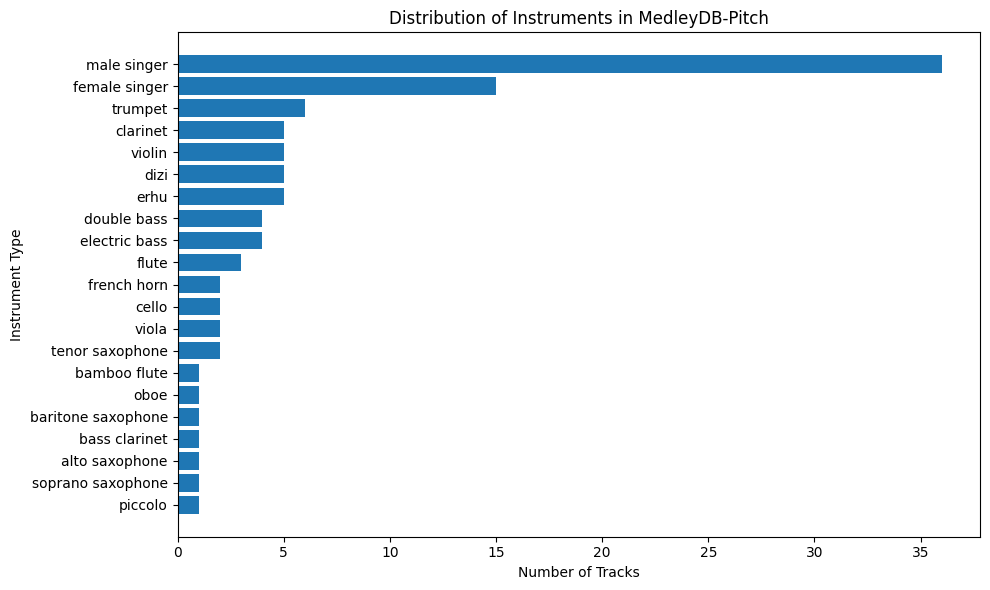

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Collect instrument field
instruments = []
for track_id in dataset.track_ids:
    track = dataset.track(track_id)
    instr = getattr(track, 'instrument', None)
    if instr:
        instruments.append(instr)
    else:
        instruments.append('Unknown')

# Count the number of each instrument
counts = Counter(instruments)

# Convert to two lists (for plotting)
labels, values = zip(*sorted(counts.items(), key=lambda x: x[1], reverse=True))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(labels, values)
plt.xlabel("Number of Tracks")
plt.ylabel("Instrument Type")
plt.title("Distribution of Instruments in MedleyDB-Pitch")
plt.gca().invert_yaxis()  # Place the most frequent at the top
plt.tight_layout()
plt.show()

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import mirdata

random.seed(42)
np.random.seed(42)

PROJECT_ROOT = '/content/drive/MyDrive/MedleyDB-Pitch-dist'
os.makedirs(PROJECT_ROOT, exist_ok=True)

DIST_LEVELS = ["light", "medium", "heavy"]
LEVEL_ID = {lvl: i for i, lvl in enumerate(DIST_LEVELS)}

dataset = mirdata.initialize("medleydb_pitch")

rows = []
for tid in dataset.track_ids:
    tr = dataset.track(tid)
    instrument = getattr(tr, "instrument", None) or "Unknown"
    audio_path = tr.audio_path
    rows.append({
        "track_id": tid,
        "instrument_raw": instrument,
        "src_audio_path": audio_path
    })

df = pd.DataFrame(rows)

# instrument to class_tag (vocal / other)
def map_class_tag(instr: str) -> str:
    s = (instr or "").lower()
    if "male singer" in s or "female singer" in s:
        return "vocal"
    return "instrument"

df["class_tag"] = df["instrument_raw"].apply(map_class_tag)

# Stratified balancing to three distortion intensities
plan = []
for cls, g in df.groupby("class_tag"):
    g = g.sample(frac=1.0, random_state=42)
    parts = np.array_split(g, len(DIST_LEVELS))
    for lvl, part in zip(DIST_LEVELS, parts):
        for _, r in part.iterrows():
            out_path = r.src_audio_path
            plan.append({
                "track_id": r.track_id,
                "class_tag": cls,
                "level_tag": lvl
            })

df_plan = pd.DataFrame(plan)

# Coverage check
pivot = df_plan.pivot_table(index="class_tag", columns="level_tag",
                            values="track_id", aggfunc="count", fill_value=0)
print("Stratified counts (class_tag × distortion level):")
print(pivot)

# Save manifest (minimal version)
csv_path = os.path.join(PROJECT_ROOT, "manifest_dist.csv")
df_plan.to_csv(csv_path, index=False)
print(f"\nSaved manifest to: {csv_path}\n")

Stratified counts (class_tag × distortion level):
level_tag   heavy  light  medium
class_tag                       
instrument     17     18      17
vocal          17     17      17

Saved manifest to: /content/drive/MyDrive/MedleyDB-Pitch-dist/manifest_dist.csv



/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
!pip install pyloudnorm

In [ ]:
# Play original audio first, then light/medium/heavy distortion
import soundfile as sf
from IPython.display import display, Audio
import pyloudnorm as pyln

PROJECT_ROOT = '/content/drive/MyDrive/MedleyDB-Pitch-dist'
MANIFEST_CSV = os.path.join(PROJECT_ROOT, 'manifest_dist.csv')

# Audition output
TEMP_OUT_DIR = os.path.abspath(os.path.join(PROJECT_ROOT, '..'))
print("Temporary output dir:", TEMP_OUT_DIR)

# Distortion intensity
LEVELS = ['light', 'medium', 'heavy']
LEVEL_DRIVE = {'light': 2.0, 'medium': 5.0, 'heavy': 7.5}

random.seed(42)
np.random.seed(42)


def distort_tanh_match_lufs(y, sr, drive=3.0, never_louder=True):
    """
    tanh distortion + LUFS matching to the integrated loudness of the original audio.
    Closer to subjective loudness consistency.
    """
    eps = 1e-12
    y = np.asarray(y)
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    meter = pyln.Meter(sr, block_size=0.400)

            out_path = r.src_audio_path

    loud_ref = meter.integrated_loudness(y)

    peak = np.max(np.abs(y)) + eps
    y0 = y / peak

    y_dist = np.tanh(drive * y0)

    loud_out = meter.integrated_loudness(y_dist)
    gain_db = loud_ref - loud_out
    gain = 10 ** (gain_db / 20.0)

    if never_louder:
        gain = min(1.0, gain)

    y_dist = y_dist * gain

    # Safe limiting
    peak_out = np.max(np.abs(y_dist)) + eps
    if peak_out > 0.999:
        y_dist = y_dist / peak_out * 0.999

    return y_dist

def make_dist_versions_for_a_track(track_id, dataset, levels=LEVELS, out_dir=TEMP_OUT_DIR):
    """
    Generates multi-intensity distorted versions for a given track_id, writes to out_dir.
    Filename: original filename + __dist={level}.wav
    Returns: (src_path, sr, [(level, out_path, sr), ...])
    """
    tr = dataset.track(track_id)
    src_path = tr.audio_path
    y, sr = sf.read(src_path, always_2d=False)
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    base = os.path.splitext(os.path.basename(src_path))[0]
    outs = []
    for lvl in levels:
        drive = LEVEL_DRIVE[lvl]
        y_out = distort_tanh_match_lufs(y, sr, drive=drive, never_louder=False)
        out_path = os.path.join(out_dir, f"{base}__dist={lvl}.wav")
        sf.write(out_path, y_out, sr, subtype='PCM_16')
        outs.append((lvl, out_path, sr))
    return src_path, sr, outs

# Read manifest
df = pd.read_csv(MANIFEST_CSV)
assert set(df['class_tag'].unique()) <= {'vocal', 'instrument'}, \
    f"class_tag contains unexpected values: {df['class_tag'].unique()}"

# Randomly select 1 vocal and 1 instrument
vocal_row = df[df['class_tag'] == 'vocal'].sample(1, random_state=19).iloc[0]
instr_row = df[df['class_tag'] == 'instrument'].sample(1, random_state=300).iloc[0]

print("Selected for audition:")
print("  vocal     :", vocal_row.track_id)
print("  instrument:", instr_row.track_id)

v_src, v_sr, v_files = make_dist_versions_for_a_track(vocal_row.track_id, dataset)
i_src, i_sr, i_files = make_dist_versions_for_a_track(instr_row.track_id, dataset)

# Play original audio first, then play three levels of distortion
print("\n[VOCAL] Original:")
display(Audio(filename=v_src, rate=v_sr))

In [ ]:
print("\n[INSTRUMENT] Original:")
display(Audio(filename=i_src, rate=i_sr))
print("[INSTRUMENT] Distorted (light/medium/heavy):")
for lvl, p, sr in i_files:
    print(f"  [{lvl}] {p}")
    display(Audio(filename=p, rate=sr))

In [ ]:

# Configuration
PROJECT_ROOT = '/content/drive/MyDrive/MedleyDB-Pitch-dist'
MANIFEST_CSV = os.path.join(PROJECT_ROOT, 'manifest_dist.csv')
OUT_DIR = os.path.join(PROJECT_ROOT, 'audio')   # Single output directory
os.makedirs(OUT_DIR, exist_ok=True)

# level_tag in manifest → drive
LEVEL_DRIVE = {
    'light': 2.0,
    'medium': 5.0,
    'heavy': 7.5,
}

SKIP_IF_EXISTS = True


def distort_tanh_match_lufs(y, sr, drive=3.0, never_louder=True):
    """
    tanh distortion + LUFS matching to the integrated loudness of the original audio.
    Closer to subjective loudness consistency.
    """
    eps = 1e-12
    y = np.asarray(y)
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    meter = pyln.Meter(sr, block_size=0.400)

    loud_ref = meter.integrated_loudness(y)

    peak = np.max(np.abs(y)) + eps
    y0 = y / peak

    y_dist = np.tanh(drive * y0)

    # Calculate LUFS after distortion, and pull back to original LUFS
    loud_out = meter.integrated_loudness(y_dist)
    gain_db = loud_ref - loud_out
    gain = 10 ** (gain_db / 20.0)

    if never_louder:
        gain = min(1.0, gain)

    y_dist = y_dist * gain

    # Safe limiting
    peak_out = np.max(np.abs(y_dist)) + eps
    if peak_out > 0.999:
        y_dist = y_dist / peak_out * 0.999

    return y_dist


def process_one(track_id, level_tag, dataset):
    """
    Distort the track once according to the manifest's level_tag, write to OUT_DIR, keeping the filename exactly the same.
    """
    if level_tag not in LEVEL_DRIVE:
        print(f"[WARN] Unknown level_tag={level_tag} for {track_id}")
        return None

    tr = dataset.track(track_id)
    src_path = tr.audio_path
    if not os.path.exists(src_path):
        print(f"[MISS] Source not found: {src_path}")
        return None

    y, sr = sf.read(src_path, always_2d=False)
    y_out = distort_tanh_match_lufs(y, sr, drive=LEVEL_DRIVE[level_tag], never_louder=False)

    fname = os.path.basename(src_path)
    out_path = os.path.join(OUT_DIR, fname)

    if SKIP_IF_EXISTS and os.path.exists(out_path):
        return out_path

    sf.write(out_path, y_out, sr, subtype='PCM_16')
    return out_path

# Main process
df = pd.read_csv(MANIFEST_CSV)

# Basic validation
required_cols = {'track_id', 'class_tag', 'level_tag'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"manifest missing columns: {missing}. Must contain: {required_cols}")

written, skipped = 0, 0
for i, row in df.iterrows():
    ret = process_one(row.track_id, row.level_tag, dataset)
    if ret is None:
        skipped += 1
    else:
        written += 1

    if (i + 1) % 20 == 0:
        print(f"Progress: {i+1}/{len(df)}")

print(f"\nDone. Written: {written}, Skipped/Missing: {skipped}")
print(f"Output dir: {OUT_DIR}")

Progress: 20/103
Progress: 40/103
Progress: 60/103
Progress: 80/103
Progress: 100/103

Done. Written: 103, Skipped/Missing: 0
Output dir: /content/drive/MyDrive/MedleyDB-Pitch-dist/audio
